In [ ]:
#|hide
import torchvision.transforms as T
import matplotlib as mpl, matplotlib.pyplot as plt
import torch.optim as optim
from fastai.vision.all import *
from torchvision.datasets import MNIST
from functools import wraps
import wandb
from fastai.callback.wandb import *
from FastFF.performance import *
from FastFF.models import moe, fff

In [ ]:
#|hide
set_seed(0)

In [ ]:
#|hide
#|eval: false
h = 32
n = 8
bs = 256

model = moe.MoE(28*28, 10, n, n, hidden_dim=h)
cbs = [ProbsDistrCB(), GetGradCB([model.gate[0], *map(lambda x: x[0], model.experts)])]
Learner(get_mnist_dls(bs), model, loss_func=F.cross_entropy, metrics=accuracy, cbs=cbs).fit_one_cycle(10, lr_max=7e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.260406,0.249530,0.925300,00:18
1,0.216368,0.189325,0.944400,00:17
2,0.166848,0.164818,0.954200,00:17
3,0.137048,0.150425,0.957200,00:17
4,0.115549,0.141497,0.961900,00:17
5,0.077134,0.136006,0.964600,00:17
6,0.057593,0.114315,0.970300,00:27
7,0.033172,0.109570,0.972000,00:19
8,0.021968,0.101854,0.974000,00:17
9,0.016227,0.102376,0.974400,00:22


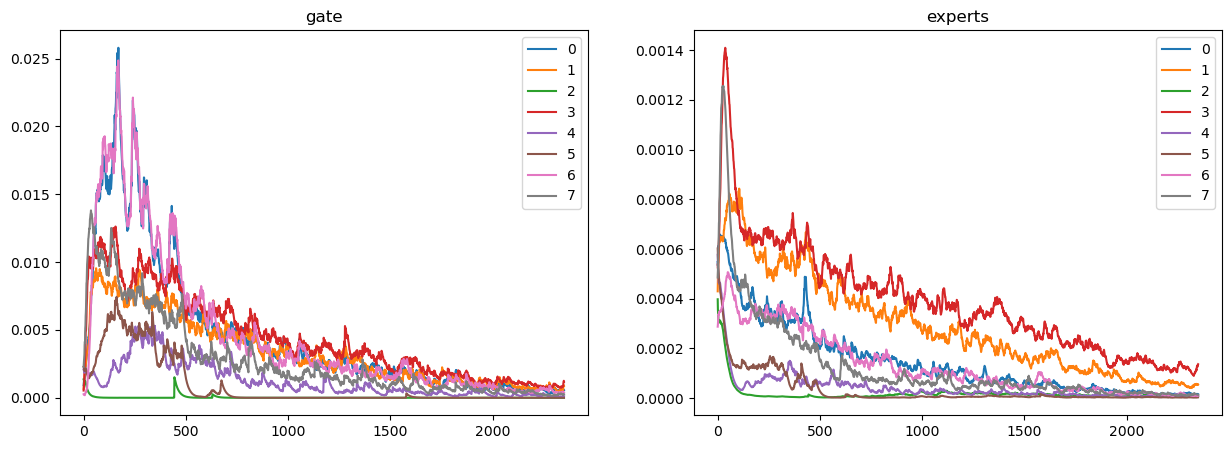

In [ ]:
#|eval: false
axes = subplots(figsize=(15,5), ncols=2)[1]
for i, k in enumerate(['gate','experts']): axes[i].title.set_text(k)
cbs[1].show(model.gate[0], lambda x: x.abs().mean(-1), ax=axes[0])
for i, l in enumerate(model.experts): cbs[1].show(l[0], ax=axes[1], label = i)

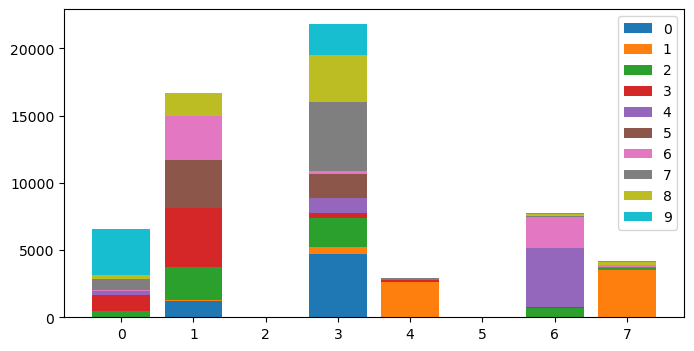

In [ ]:
#|eval: false
ax = subplots(figsize=(8,4))[1][0]
cbs[0].show(-1, ax=ax)

## Sweep

In [ ]:
sweep_cfg = {
    'method': 'grid',
    'metric':{'name': 'valid_loss','goal':'minimize'},
    'parameters':{
        'bs': {'value': 256},
        'learn':{'parameters':{'lr_max': {'value':7e-3}}},
        'model':{'parameters':{
            'h': {'values': [8,16,32]},
            'd': {'values': [1,2,3,4]},
            'act': {'value': 'relu'},
            }},
        'epochs': {'value': 10}
    }
}

def run(cfg, run):
    run.name = ' '.join(f'{k}={v}' for k,v in cfg.model.items())
    model = moe.MoE(28*28, 10,  2**cfg.model['d'], 2**cfg.model['d'], hidden_dim=cfg.model['h'])
    cbs = [WandbCallback(log_preds=False), GetGradCB([model.gate[0], *map(lambda x: x[0], model.experts)]), ProbsDistrCB(wandb = True, sample_size=100)]
    Learner(get_mnist_dls(cfg.bs), model, F.cross_entropy, metrics=accuracy, cbs=cbs).fit_one_cycle(cfg.epochs, lr_max=cfg.learn['lr_max'])
    fig, axes = subplots(figsize=(15,5), ncols=2)
    for i, k in enumerate(['gate','experts']): axes[i].title.set_text(k)
    cbs[1].show(model.gate[0], lambda x: x.abs().mean(-1), ax=axes[0])
    for i, l in enumerate(model.experts): cbs[1].show(l[0], ax=axes[1], label = i)
    wandb.log({'gradients plot':fig})

In [ ]:
# runs_sweep(sweep_cfg, 'FFF', 12, 'Mixture of experts')(run)